## Racetrack (5.12)

Action space is determined by adjustments to vertical and horizontal velocities

In [1]:
import itertools

actions_horizontal = [-1,0,1]
actions_vertical = [-1,0,1]
action_space = list(itertools.product(actions_horizontal, actions_vertical))
print(f"Action space is: {len(action_space)} dimensional")
action_space

Action space is: 9 dimensional


[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]

To visualize the problem, we generate a racetrack of 31 x 15 space. We consider the top part to be the starting line and the bottom right the finish line

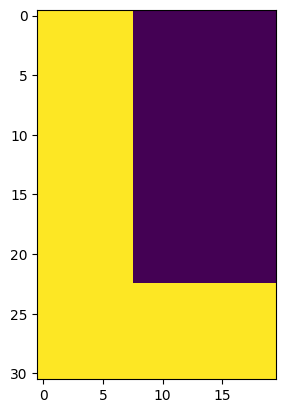

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def create_racetrack(rows, columns, lanewidth):
    racetrack = np.ones((rows, columns), dtype=np.uint8)
    racetrack[:rows-lanewidth,lanewidth:] = 0
    return racetrack

racetrack_ex = create_racetrack(31,20,8)
plt.imshow(racetrack_ex)
plt.show()

Let's simulate a starting position at (0,3) which is the bottom of the map. Valid runway is shown in yellow with sample starting position represented in the red dot

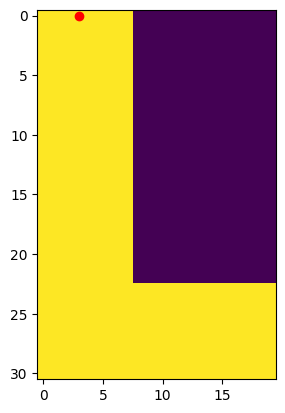

In [3]:
# We need this helper function to plot the dot over the racetrack considering that
# the plt.imshow inverts the coordinate of reference
def plot_dot_over_racetrack(row, column, racetrack):
  plt.imshow(racetrack)
  plt.plot(column, row, 'ro')
  plt.show()

start_pos_ex = (0,3)
plot_dot_over_racetrack(*start_pos_ex, racetrack_ex)

We can implement functions for getting the next position of the car based on its current velocity and position. So, for the previous starting position and a velocity of (0,0) this leads to the following

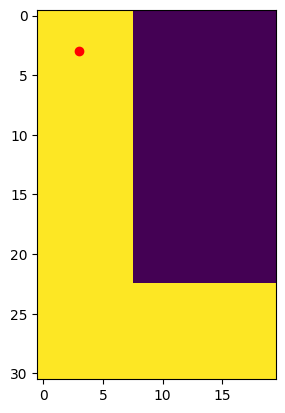

In [4]:
def next_position(pos_row, pos_column, vel_row, vel_col):
    return pos_row + vel_row, pos_column + vel_col

next_pos_ex = next_position(*start_pos_ex,3,0)
plot_dot_over_racetrack(*next_pos_ex, racetrack_ex)

It is also helpful to have a way to know if the next position, based on current position and velocity, would lead to a boundary crash. Following the previous example, if we had a velocity of (0, 5) following the last position, it would crash with the boundary.

In [131]:
class PossibleOutcomes:
  crash = 0
  finish = 1
  inrace = 2

# we assume that a diagonal trajectory near the finish line, that ends with
# the car beyond the racetrack height is invalid, to simplify
def check_next_condition(pos_row, pos_column, vel_row, vel_column, racetrack):
  next_row, next_col = next_position(pos_row, pos_column, vel_row, vel_column)
  in_height = next_row < racetrack.shape[0] and next_row >= 0
  if (in_height and next_col >= racetrack.shape[1]-1 and
      racetrack[next_row][racetrack.shape[1]-1] == 1):
    return PossibleOutcomes.finish
  in_width = next_col < racetrack.shape[1] and next_col >= 0
  if not in_height or not in_width:
    return PossibleOutcomes.crash
  elif racetrack[next_row][next_col] == 0:
    return PossibleOutcomes.crash
  return PossibleOutcomes.inrace

crash_ex = check_next_condition(*next_pos_ex, 0, 5, racetrack_ex)
print(f"Car at position {next_pos_ex} moved by velocity (0,5) crashes? {crash_ex==PossibleOutcomes.crash}")
not_crash_ex = check_next_condition(*next_pos_ex,0,2, racetrack_ex)
print(f"Car at position {next_pos_ex} moved by velocity (0,2) crashes? {not_crash_ex==PossibleOutcomes.crash}")

Car at position (3, 3) moved by velocity (0,5) crashes? True
Car at position (3, 3) moved by velocity (0,2) crashes? False


### Policy

To implement the policy, the state will be represented as:

`[pos_row, pos_col, vel_row, vel_col]`

And the agent can take an action as:

`[acc_row, acc_col]`

We proceed by implementing a helper function to create the action space

In [6]:
def create_action_space():
  actions_horizontal = [-1,0,1]
  actions_vertical = [-1,0,1]
  action_space = list(itertools.product(actions_horizontal, actions_vertical))
  return action_space

action_space_rt = create_action_space()
print(f"Action space is: {action_space_rt}")

Action space is: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]


Now, since velocities should be both in the range `]0,5]` except for the initial state, it is useful to create a helper function to filter to all valid actions for a given state (given by velocities)

In [42]:
def check_if_valid_action(velocities, accelerations):
    new_row_vel = velocities[0] + accelerations[0]
    new_col_vel = velocities[1] + accelerations[1]
    if new_row_vel == 0 and new_col_vel == 0:
      return False
    elif new_row_vel < 0 or new_col_vel < 0:
      return False
    elif new_row_vel >= 5 or new_col_vel >= 5:
      return False
    return True

def init_actions_for_state(state, action_space):
    valid_actions = []
    for action in action_space:
      if check_if_valid_action(state[2:],action):
        valid_actions.append(action)
    return valid_actions

def action_equality(ac1, ac2):
    for i1, i2 in zip(ac1, ac2):
      if i1 != i2:
        return False
    return True

valid_actions_init = init_actions_for_state([0,0,0,0], action_space_rt)
print(f"Valid actions for an initial state of: [0,0,0,0] are: {valid_actions_init}")


Valid actions for an initial state of: [0,0,0,0] are: [(0, 1), (1, 0), (1, 1)]


It follows a policy implementation for the e-greedy monte carlo

In [43]:
import numpy as np
import pprint

def build_state_key(state):
  return "_".join([str(s) for s in state])

class FirstVisitMCPolicy:
    """
    Implements Monte Carlo e-greedy policy

    """
    def __init__(self, action_space, epsilon):
        self.epsilon = epsilon
        self.action_space = action_space
        self.policy = {}

    def _init_state_policy(self, state):
        valid_actions = init_actions_for_state(state, self.action_space)
        self.policy[build_state_key(state)] = {
            "actions":valid_actions,
            "probs":[1/len(valid_actions) for _ in valid_actions]
        }

    def _compute_new_policy_value(self, action, max_action, n_actions):
        if not action_equality(action, max_action):
            return self.epsilon/n_actions
        return 1 - self.epsilon + self.epsilon/n_actions

    def update(self, state, max_action):
        state_key = build_state_key(state)
        n_actions = len(self.policy[state_key]["actions"])
        for ac_id, action in enumerate(self.policy[state_key]["actions"]):
          self.policy[state_key]["probs"][ac_id] = self._compute_new_policy_value(
              action, max_action, n_actions
          )

    def sample_action(self, state):
        state_key = build_state_key(state)
        if state_key not in self.policy:
          self._init_state_policy(state)
        action_probs = self.policy[state_key]["probs"]
        action_indices = [i for i in range(len(action_probs))]
        sampled_action_id = np.random.choice(action_indices, p = action_probs)
        return self.policy[state_key]["actions"][sampled_action_id]


# For an initial state of [0,0,0,0] there are 3 possible actions:
# (0,1) - (1,0) - (1,1)
agent = FirstVisitMCPolicy(action_space_rt, 0.1)
state_example = [0,0,0,0]
sampled_action = agent.sample_action(state_example)
print(f"Sampled action: {sampled_action} for state: {state_example}")
print("Policy for that state:")
# Action probabilities are initialized to uniform distribution
pprint.pprint(agent.policy['0_0_0_0'])

Sampled action: (1, 0) for state: [0, 0, 0, 0]
Policy for that state:
{'actions': [(0, 1), (1, 0), (1, 1)],
 'probs': [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]}


In [44]:
agent.update(state_example, [1,0])
pprint.pprint(agent.policy["0_0_0_0"])
assert np.isclose(sum(agent.policy["0_0_0_0"]["probs"]),1,1e-12)

{'actions': [(0, 1), (1, 0), (1, 1)],
 'probs': [0.03333333333333333, 0.9333333333333333, 0.03333333333333333]}


### Action-Value Function

We implement a class for the action value function

In [170]:
import random

class QFunction:
  def __init__(self, action_space):
    self.values = {}
    self.action_space = action_space

  def _init_q_values(self, state):
    valid_actions = init_actions_for_state(state, self.action_space)
    action_values = [random.randint(1,10) for a in valid_actions]
    self.values[build_state_key(state)] = {
        "actions":valid_actions,
        "values":action_values
    }

  def _get_action_id(self, actions, action):
    for id, act in enumerate(actions):
      if action_equality(action,act):
        return id


  def get_max_action(self, state):
    s_key = build_state_key(state)
    if s_key not in self.values:
      self._init_q_values(state)
    actions = self.values[s_key]["actions"]
    action_values = self.values[s_key]["values"]
    return actions[np.argmax(action_values)]

  def get_value(self, state, action):
    s_key = build_state_key(state)
    if s_key not in self.values:
      self._init_q_values(state)
    act_id = self._get_action_id(self.values[s_key]["actions"], action)
    if act_id is None:
      raise ValueError(f"No action: {action} registered for state: {state}")

  def update(self, state, action, new_value):
    s_key = build_state_key(state)
    if s_key not in self.values:
      self._init_q_values(state)
    action_id = self._get_action_id(self.values[s_key]["actions"],action)
    if action_id is None:
      raise ValueError(f"No action: {action} is recorded for state: {state}")
    self.values[s_key]["values"][action_id] = new_value


q_example = QFunction(action_space_rt)
# we initialize action and values for initial state
q_example.get_value(state_example, (0,1))
pprint.pprint(q_example.values)
# we sample maximal action for that state
print(f"Maximal action is {q_example.get_max_action(state_example)}")
# if we update action (1,0) with a value of 100, it should become maximal action
q_example.update(state_example, (1,0), 100)
assert q_example.get_max_action(state_example) == (1,0)

{'0_0_0_0': {'actions': [(0, 1), (1, 0), (1, 1)], 'values': [2, 10, 7]}}
Maximal action is (1, 0)


### RaceTrackEnv

We create a racetrack environment for generating episodes according to the rules

In [171]:
import random

class RaceTrackEnv:
  def __init__(self, width, height, lanewidth):
    self.rows = height
    self.columns = width
    self.lanewidth = lanewidth
    self.racetrack = create_racetrack(height, width, lanewidth)
    self.reset()

  def _select_random_init_state(self):
    col =  random.randint(0,self.lanewidth-1)
    return [0, col, 0, 0]

  def _update_last_state(self, row_acc, col_acc):
    new_row_vel = self.last_state[2] + row_acc
    new_col_vel = self.last_state[3] + col_acc
    new_row = self.last_state[0] + new_row_vel
    new_col = self.last_state[1] + new_col_vel
    self.last_state = [new_row, new_col, new_row_vel, new_col_vel]

  def reset(self):
    self.last_state = self._select_random_init_state()
    return self.last_state

  def step(self, action) -> tuple[tuple, int, bool]:
    """
    return state, reward, done
    """
    new_row_vel = self.last_state[2] + action[0]
    new_col_vel = self.last_state[3] + action[1]
    next_condition = check_next_condition(
        self.last_state[0],
        self.last_state[1],
        self.last_state[2],
        self.last_state[3],
        self.racetrack
    )
    if next_condition == PossibleOutcomes.crash:
      self.reset()
      return self.last_state, -1, False
    if next_condition == PossibleOutcomes.finish:
      return self.last_state, 0, True
    self._update_last_state(*action)
    return self.last_state, -1, False

env_test = RaceTrackEnv(40,30,10)
print(f"Initial state: {env_test.last_state}")
env_test.step((1,1))
print(f"New state: {env_test.last_state} after acceleration of (1,1)")


Initial state: [0, 4, 0, 0]
New state: [1, 5, 1, 1] after acceleration of (1,1)


#### Trajectory Plotter

Sort of a more sophisticated version of the plotting function implemented earlier, this time to plot the whole trajectory of the car

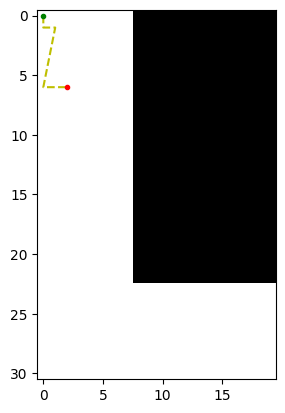

In [172]:
import matplotlib.pyplot as plt

def plot_trajectory(trajectory, racetrack):
  rows, cols = [], []
  for s in trajectory:
    rows.append(s[0])
    cols.append(s[1])
  plt.imshow(racetrack, cmap="bone")
  plt.plot(cols, rows, '--y')
  plt.plot(cols[0],rows[0],".g")
  plt.plot(cols[-1], rows[-1],".r")
  plt.show()

plot_trajectory([[0,0],[1,0],[1,1],[6,0],[6,2]],racetrack_ex)

### Episode loop helper

Function to run an episode given the racetrackenv and policy



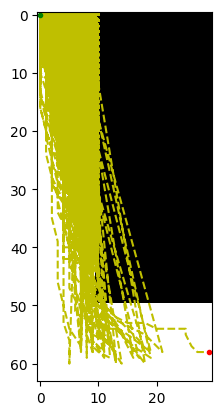

In [177]:
def run_episode(env, policy) -> tuple[list[tuple],list[tuple],list[int]]:
  done = False
  actions = []
  rewards = []
  trajectory = []
  state = env.reset()
  while not done:
    action = policy.sample_action(state)
    actions.append(action)
    trajectory.append(state)
    state, rew, done = env.step(action)
    rewards.append(rew)
  return trajectory, actions, rewards



env_test = RaceTrackEnv(30,60,10)
policy_test = FirstVisitMCPolicy(create_action_space(),epsilon = 1e-3)

trajectory_test, actions_test, rewards_test = run_episode(env_test, policy_test)
assert len(trajectory_test) == len(actions_test)
assert len(actions_test) == len(rewards_test)
plot_trajectory(trajectory_test, env_test.racetrack)

### On-policy first-visit MC Control

In [178]:
def create_visited_dict(state_list, action_list):
  visited = {}
  for i, (state,action) in enumerate(zip(state_list, action_list)):
    key = build_state_key(state + list(action))
    if key not in visited:
      visited[key] = i
  return visited

states_t = [[0,0,0,0],[0,1,0,0],[0,0,0,0]]
actions_t = [[1,0],[0,1],[1,0]]
visited_t = create_visited_dict(states_t, actions_t)
pprint.pprint(visited_t)
assert len(visited_t) == 2

{'0_0_0_0_1_0': 0, '0_1_0_0_0_1': 1}


In [ ]:
import numpy as np

DISCOUNT_FACTOR = 0.9
N_EPISODES = 100

env = RaceTrackEnv(30,60,10)
policy = FirstVisitMCPolicy(create_action_space(),epsilon = 1e-3)
q_function = QFunction(create_action_space())
returns = {}

for episode in range(N_EPISODES):
  states, actions, rewards = run_episode(env, policy)
  visited = create_visited_dict(states, actions)
  last_rew = 0
  for t in range(len(states)-1,-1,-1):
    # recompute last reward
    last_rew = last_rew*DISCOUNT_FACTOR + rewards[t]
    # check if state action appears earlier
    state = states[t]
    action = actions[t]
    key = build_state_key(state + list(action))
    if key in visited and visited[key] < t:
      continue

    # create return entry for state_action key
    if key not in returns:
      returns[key] = []

    # add new return to this state-action pair
    returns[key].append(last_rew)
    # update q function and policy
    q_function.update(states[t],actions[t],np.mean(returns[key]))

    # find maximal action given new q function
    max_action = q_function.get_max_action(state)

    # update policy
    policy.update(state, max_action)

  print(f"Episode: {episode}")
  plot_trajectory(states, env.racetrack)

